# Real News vs The Onion

This project aims to investigate the possibility of using machine learning to train a discriminator to correctly identify real versus fake news headlines. As stated, the scope of this project is rather broad and ambitious so we offer a much more reasonable sub-problem: create a machine learning model which can classify posts from ```r/news``` against those from ```r/TheOnion``` using only the post titles alone.

For the purposes of accomplishing this goal, we attempted to scrape 100,000 posts from each subreddit. While we were successfully able to scrape 100,000 posts from ```r/news```, our webscraper only returned approximately 17,000 posts from ```r/TheOnion```. Cleaning the data involved purging duplicate titles and non-ASCII encoded titles; the reader may check this process in the ```data-prep.ipynb``` notebook. After this cleaning process, we were left with a training set of approximately 80,000 posts: 70,000 from ```r/news``` and 10,000 from ```r/TheOnion```. Once a final model has been selected from amongst all of our models, we will evaluate its performance on 9,000 posts which we hold in reserve.

We should remark here: our webscraper collected the data sequentially by creation time. Thus posts were scraped based on how recently they were created. Most of the posts we scraped from ```r/news``` thus were posts from either the past few months or the past year. Thus it is highly likely that many of the posts from ```r/news``` have a recency bias in terms of topics, word appearances, and references. This is important to keep in mind any results using word frequency modelling might require further training on an older dataset of news headlines.

Let us begin with some exploratory data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import thor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/total_train.csv')[['title', 'class']]

test = pd.read_csv('../data/total_test.csv')

test.shape

(8926, 3)

- Let's lower case all the words to make counting and parsing easier.

In [3]:
train['title'] = train['title'].str.lower()

In [4]:
# take a look at the size of the data
train.shape

(80329, 2)

- So we have 80,000 news headlines gathered from ```r/news``` and ```r/TheOnion```.
- Let's also take a look at the class sizes and see what kind of baseline accuracy we should expect from our models.

In [5]:
train['class'].value_counts(normalize=True)

0    0.873196
1    0.126804
Name: class, dtype: float64

- We have an imbalance between the classes: ```r/news``` posts outnumber ```r/TheOnion``` posts at a ratio of more than 7:1.
- This imbalance may or may not exist in the real world, but since we do not have the expertise to decide this, we keep the data as-is and treat this as an imbalanced class problem.

In [6]:
# Remove Stop words
stops = set(stopwords.words('english'))

cleaned = thor.tokenize(train['title']).map(lambda x: ' '.join([word for word in x if word not in stops]))

In [7]:
cleaned = pd.concat([cleaned, train['class']], axis=1)

cleaned.head()

,title,class
0,sheriff office removes photo santa filling gun...,0
1,library lets borrow people instead books may h...,0
2,russian elements infiltrated every element eur...,0
3,drivers left alive go final nascar race season,1
4,happens ukraine since 2015,0


---

# Word Frequencies

In [8]:
# split the real news headlines from the onion headlines
news = cleaned[ cleaned['class'] == 0 ]
onion = cleaned[ cleaned['class'] == 1 ]

In [9]:
onion.head()

,title,class
3,drivers left alive go final nascar race season,1
8,said find ruth bader ginsburg phil knight rond...,1
33,trump insists never thought firing mueller fee...,1
41,post video facebook let friends know officiall...,1
50,immigrant children terrified ghastly visage la...,1


In [10]:
# An example headline from r/TheOnion
train.loc[48, 'title']

'antifungal drugs market opportunity analysis, trends, and business strategies | forecast- 2023'

In [11]:
# Let's take at the most common words in r/TheOnion articles
onion_count = thor.count_words(onion['title'])

onion_top10 = onion_count.sort_values(ascending=False)[0:10]

onion_top10

new       615
man       603
life      551
trump     479
find      438
say       427
news      425
said      405
onion     333
report    254
dtype: int64

- We see that "Trump" makes an appearance in the top 10 for ```r/TheOnion```.
- Other notable words: "man", "find", "report". Seems that most Onion headlines tend to sound vague, nebulous, and anonymous.

In [12]:
# Let's do the same for r/news
news_count = thor.count_words(news['title'])

news_top10 = news_count.sort_values(ascending=False)[0:10]

news_top10 

covid      3469
ukraine    3414
new        3184
says       2546
russia     2452
us         2444
news       2131
2022       1994
man        1871
russian    1836
dtype: int64

- Not surprisingly, most of the articles in ```r/news``` are dominated by recent events such as covid and Ukraine.

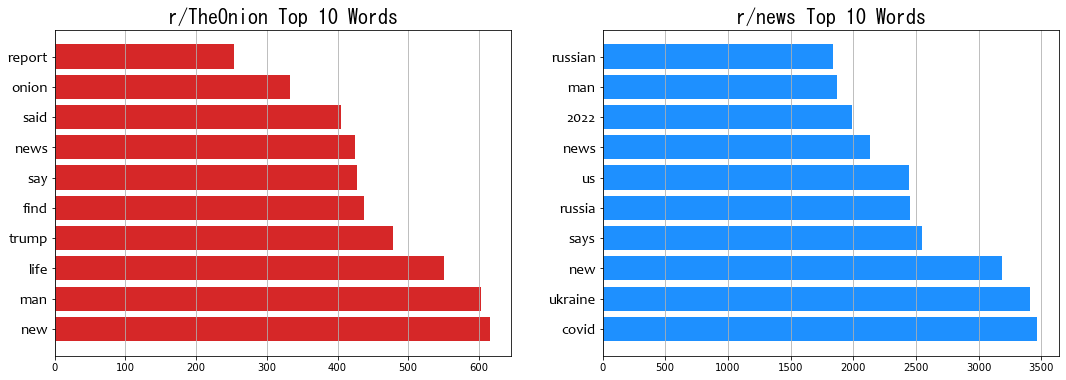

In [13]:
# Let's visualize this datum
fig, ax = plt.subplots(1,2,figsize=(18,6));

ax[0].barh(y=onion_top10.index, width = onion_top10, color = 'tab:red');
ax[0].set_title('r/TheOnion Top 10 Words', fontsize=20, font='ms gothic');
ax[0].set_yticklabels(onion_top10.index, fontsize=15, font='candara');
ax[0].grid(axis='x');

ax[1].barh(y=news_top10.index, width = news_top10, color = 'dodgerblue');
ax[1].set_title('r/news Top 10 Words', fontsize=20, font='ms gothic');
ax[1].set_yticklabels(news_top10.index, fontsize=15, font='candara');
ax[1].grid(axis='x');

plt.savefig('../images/top10words.png');

---

# Name Frequencies

One thing that might be interesting is the occurences of names between news and Onion headlines. We already saw that "Trump" cracked the top 10 in ```r/TheOnion``` but let's see if there are others worth paying attention to. 

One good place to start is by looking at some word leaders and important political figures/government officials.

In [14]:
names = ['trump', 'biden', 'putin', 'macron', 'johnson', 'trudeau', 'zelensky', 'ketanji', 'fauci', 'xi', 'mcconnell']

In [15]:
def get_counts_for(arr, word):
    if word in arr.index:
        return (word, arr[word])
    
    else:
        return (word, 0)

    
    
onion_names_ct = [get_counts_for(onion_count, name) for name in names]
news_names_ct = [get_counts_for(news_count, name) for name in names]

In [16]:
print(onion_names_ct)
print(news_names_ct)

[('trump', 479), ('biden', 98), ('putin', 19), ('macron', 1), ('johnson', 19), ('trudeau', 5), ('zelensky', 0), ('ketanji', 2), ('fauci', 2), ('xi', 3), ('mcconnell', 10)]
[('trump', 1008), ('biden', 1456), ('putin', 847), ('macron', 40), ('johnson', 188), ('trudeau', 70), ('zelensky', 142), ('ketanji', 38), ('fauci', 133), ('xi', 63), ('mcconnell', 18)]


- We can normalize these counts to get a better idea of their distributions, but we can also make some rough observations by keeping in mind that the ratio of ```r/TheOnion``` to ```r/news``` posts are approximately 1:7 and then comparing the ratios for the corresponding words:
    - "Trump" shows up at a ratio of approximately 2:5 between ```r/TheOnion``` and ```r/news```.
    - "Biden" Shows up at a ratio of approximately 1:14.
    - "Putin" shows up at a ratio of approximately 1:42.
    - "Macron" shows up at a ratio of exactly 1:37.
    - "Johnson" shows up at a ratio of approximately 1:10.
    - "Trudeau" shows up at a ratio of approximately 1:24.
    - "Zelensky" doesn't even show up in ```r/TheOnion```.
    - "Ketanji" shows up at a ratio of exactly 1:17.
    - "Fauci" shows up at a ratio of approximately 1:64.
    - "Xi" shows up at a ratio of approximately 1:21.
    
- Look at the ratios, it's quite clear that the ```r/TheOnion``` posts we currently have are slightly less likely to reference a world leader than ```r/news``` posts. The exception to this rule is "Trump".
- That being said: there is a temporal element that must be considered here. We scraped posts in post order. It might very well be the case that we scraped almost all ```r/TheOnion``` posts dating a few years back, but only managed to scraped the 70,000 most recent ```r/news``` posts which only go back a few months.

In [17]:
# Let's also try some celebrity figures
celebs = ['kardashian', 'madonna', 'kanye', 'jenner','lebron', 'bezos', 'gates', 'musk', 'cruise', 'rowling']

onion_celebs_ct = [get_counts_for(onion_count, name) for name in celebs]
news_celebs_ct = [get_counts_for(news_count, name) for name in celebs]

print(onion_celebs_ct)
print(news_celebs_ct)

[('kardashian', 3), ('madonna', 1), ('kanye', 12), ('jenner', 6), ('lebron', 17), ('bezos', 14), ('gates', 15), ('musk', 26), ('cruise', 5), ('rowling', 9)]
[('kardashian', 59), ('madonna', 11), ('kanye', 83), ('jenner', 21), ('lebron', 16), ('bezos', 47), ('gates', 55), ('musk', 288), ('cruise', 47), ('rowling', 7)]


- Roughly speaking, it seems that "Bezos" and "Gates" tend to have a larger appearance rate in ```r/TheOnion``` than in ```r/news```.
- Quite interestingly: "Kardishian" shows up less often than "Jenner" in ```r/TheOnion``` even though the situation is flipped in ```r/news```

In [18]:
# Let's visualize this with a scatterplot
name_cts = {name[0][0]:[name[0][1],name[1][1]] for name in zip(onion_names_ct, news_names_ct)}
celeb_cts = {name[0][0]:[name[0][1],name[1][1]] for name in zip(onion_celebs_ct, news_celebs_ct)}

name_df = pd.concat([pd.DataFrame(data=name_cts, index=['onion', 'news']),pd.DataFrame(data=celeb_cts, index=['onion', 'news'])], axis=1).T

In [19]:
name_df

,onion,news
trump,479,1008
biden,98,1456
putin,19,847
macron,1,40
johnson,19,188
trudeau,5,70
zelensky,0,142
ketanji,2,38
fauci,2,133
xi,3,63


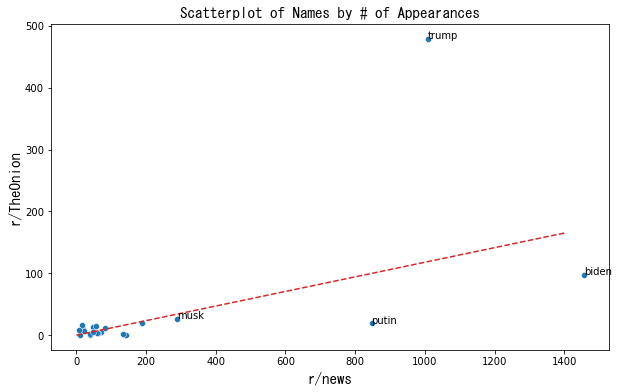

In [20]:
plt.figure(figsize=(10,6));
sns.scatterplot(x=name_df['news'], y=name_df['onion']);
plt.plot([0,1400],[0,165], linestyle='--', color='tab:red');
plt.title('Scatterplot of Names by # of Appearances', fontsize=15, font='ms gothic');
plt.xlabel('r/news', fontsize=15, font='ms gothic');
plt.ylabel('r/TheOnion', fontsize=15, font='ms gothic')

for name in ['trump', 'biden', 'putin', 'musk']:
    plt.text(name_df.loc[name,'news'], name_df.loc[name,'onion'], name)
    
plt.savefig('../images/names-scatter.png')

- The red line here is given by the equation $y=\frac{1}{7}x$ and represents the ratio between ```r/TheOnion``` posts and ```r/news``` posts. We see that most names generally, hover around the line with the exceptions of "Putin" and "Trump" (and possibly even "Biden").

---

# Title Lengths and Word Count

In [21]:
# get the number of words in each title
onion['word_count'] = thor.tokenize(onion['title']).map(lambda x: len(x))

news['word_count'] = thor.tokenize(news['title']).map(lambda x: len(x))

In [22]:
onion.head()

,title,class,word_count
3,drivers left alive go final nascar race season,1,8
8,said find ruth bader ginsburg phil knight rond...,1,10
33,trump insists never thought firing mueller fee...,1,15
41,post video facebook let friends know officiall...,1,9
50,immigrant children terrified ghastly visage la...,1,9


- Let's take a quick look at the distribution of word count for ```r/news``` posts and ```r/TheOnion``` posts.

In [23]:
onion.word_count.describe()

count    10186.000000
mean         8.393776
std          3.345900
min          0.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         30.000000
Name: word_count, dtype: float64

In [24]:
news.word_count.describe()

count    70143.000000
mean         8.665797
std          4.142809
min          0.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         59.000000
Name: word_count, dtype: float64

- For the most part, the distributions look almost identical here.

In [25]:
train['word_count'] = thor.tokenize(train['title']).map(lambda x: len(x))
cleaned['word_count'] = thor.tokenize(cleaned['title']).map(lambda x: len(x))

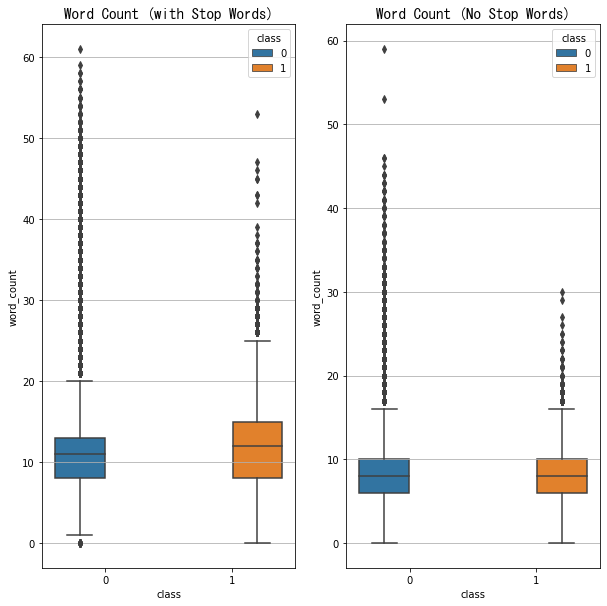

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10, 10));
sns.boxplot(x='class', y='word_count', hue='class', data=train, ax=ax[0]);
ax[0].set_title('Word Count (with Stop Words)', fontsize=15, font='ms gothic');
ax[0].grid(axis='y');

sns.boxplot(x='class', y='word_count', hue='class', data=cleaned, ax=ax[1]);
ax[1].set_title('Word Count (No Stop Words)', fontsize=15, font='ms gothic');
ax[1].grid(axis='y');

plt.savefig('../images/word_counts_box.png')

- With the Stop Words: ```r/TheOnion``` posts tend to have slightly longer titles than ```r/news``` posts.
- Without the Stop Words: ```r/TheOnion``` posts and ```r/news``` posts tend to have about the same number of words in their titles.

This suggests that ```r/TheOnion``` headlines tend to contain more stop words than real news headlines. This makes intuitive sense if we consider it for a moment: real news headlines generally want to compactly and concisely communicate information in the title while this is not a priority for ```r/TheOnion``` headlines.